# System analysis

In [1]:
import pickle
import analysis_utils
import plot_utils
from collections import defaultdict, OrderedDict
import math
from scipy.stats import pearsonr, spearmanr
import numpy as np
from scipy.stats import kendalltau
import pandas as pd
from scipy.stats import entropy
from copy import deepcopy

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


sns.set_style("whitegrid")

In [3]:
debug=False

### 1) Load data from BIN files

In [4]:
#wes_title='wes2015'
n3_title='n3'
aida_title='aida'
#rss_title='rss500'
#reuters_title='reuters128'
titles=[aida_title, n3_title]# rss_title, reuters_title]#, wes_title]
systems=['agdistis', 'spotlight', 'wat']

In [5]:
### Load data from disk
system_data_articles={}
for system in systems:
    system_data_articles[system]={}
    for data_title in titles:
        with open('bin/%s_%s.bin' % (data_title, system), 'rb') as outfile:
            system_data_articles[system][data_title]=pickle.load(outfile)

#### [DEBUG-only] Store agdistis output to a file

In [6]:
if debug:
    with open('debug/agdmag_aida_debug.tsv', 'w') as w:
        w.write('collection\tarticle_ID\tbegin_index\tend_index\tmention\tgold_link\tsystem_link\n')
        for article in aida_agd_articles:
            for mention in article.entity_mentions:
                if mention.sys_link.startswith('http://aksw.org/'):
                    mention.sys_link = '--NME--'

                a_row=[article.collection, str(article.identifier), 
                       str(mention.begin_index), str(mention.end_index), 
                       mention.mention, mention.gold_link, 
                       mention.sys_link]
                w.write('\t'.join(a_row) + '\n')

**1.1. Pick dataset**

In [7]:
system_articles = {}

for system in systems:
    system_articles[system]=set()
    for data_title in titles: 
        system_articles[system] |= system_data_articles[system][data_title]

**1.2. Normalize AGDISTIS NILs given as custom AKSW URIs **

In [8]:
for article in system_articles['agdistis']:
    for mention in article.entity_mentions:
        if mention.sys_link.startswith('http://aksw.org/'):
            mention.sys_link = '--NME--'


### 2) Performance

<span style="background-color:lightgreen">Section 6.1. of the paper</span>

#### 2.1. Overall

In [9]:
skip_nils=True
skip_nonnils=False

In [10]:
all_sys_accs = defaultdict(dict)
for system in systems:
    print(system.upper())
    sys_acc=analysis_utils.overall_performance_prf(system_articles[system], 
                                               skip_nils, 
                                               skip_nonnils)
    all_sys_accs[system]['overall']=sys_acc
#    scores.append(['overall', system, sys_acc])
    print(sys_acc)
    print()


AGDISTIS
16959 9015 12032
0.6529221529221529 0.5849746473043358 0.6170835986536887
0.6170835986536887

SPOTLIGHT
21150 5505 7841
0.7934721440630276 0.7295367527853471 0.7601624555224096
0.7601624555224096

WAT
19027 2420 9964
0.8871637058796102 0.6563071297989032 0.7544708354811849
0.7544708354811849



#### 2.2. Only forms that are interpretted as NILs and not-NILs

In [11]:
for system in systems:
    interpretations, references = analysis_utils.get_interpretations_and_references(system_articles[system], skip_nils=False)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    nil_nonnil_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            if '--NME--' in interpretations[form]:
                nil_nonnil_forms.add(form)

    nn_f_acc=analysis_utils.compute_prf_on_selection(system_articles[system], nil_nonnil_forms)
    print(system, nn_f_acc)
    all_sys_accs[system]['forms with nils & non-nils']=nn_f_acc
#    scores.append(['forms with nils & non-nils', system, nn_f_acc])

1258 1401 1125
0.4731101918014291 0.5279060008392782 0.4990083300277668
agdistis 0.4990083300277668
1473 1389 847
0.5146750524109015 0.6349137931034483 0.5685063681976071
spotlight 0.5685063681976071
1739 929 718
0.6517991004497751 0.7077737077737077 0.6786341463414635
wat 0.6786341463414635


#### 2.3. Only ambiguous forms

In [12]:
for system in systems:
    interpretations, references = analysis_utils.get_interpretations_and_references(system_articles[system], skip_nils=True)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    ambiguous_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            ambiguous_forms.add(form)

    amb_f_acc=analysis_utils.compute_prf_on_selection(system_articles[system], ambiguous_forms)
    print(system, amb_f_acc)
    all_sys_accs[system]['ambiguous forms']=amb_f_acc
#    scores.append(['ambiguous forms', system, amb_f_acc])

4324 4843 5707
0.47169193847496454 0.43106370252218124 0.4504635899572872
agdistis 0.4504635899572872
6502 3446 3498
0.6535987133092079 0.6502 0.6518949268097053
spotlight 0.6518949268097053
6108 1665 3922
0.785796989579313 0.6089730807577268 0.6861764871089142
wat 0.6861764871089142


** 2.4. Prepare and plot **

In [13]:
scores=analysis_utils.prepare_scores_to_plot(all_sys_accs)

['overall', 'ambiguous forms', 'forms with nils & non-nils']
['agdistis' 'spotlight' 'wat']
width: 0.2333333333333333
evaluation: overall
0.6170835986536887
0.7601624555224096
0.7544708354811849
evaluation: ambiguous forms
0.4504635899572872
0.6518949268097053
0.6861764871089142
evaluation: forms with nils & non-nils
0.4990083300277668
0.5685063681976071
0.6786341463414635


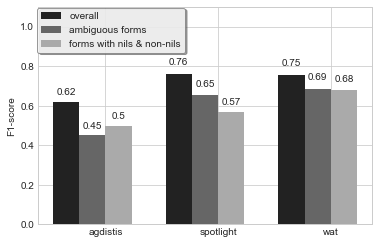

In [14]:
plot_utils.plot_scores(scores, title='Scores of systems')
#plot_scores(scores, title='Scores of systems')

### 3) Correlation between FORM frequency and accuracy

<span style="background-color:lightgreen">Section 6.2. of the paper</span>

In [15]:
acc_by_form = {system: defaultdict(float) for system in systems}
for system in systems:
    acc_by_form[system], forms_by_count = plot_utils.compute_accuracy_by_form(
        system_articles[system], skip_nils)

In [16]:
forms_by_log_count=analysis_utils.counts_to_log_counts(forms_by_count)

In [17]:
freq_intervals = analysis_utils.get_freq_intervals(forms_by_count)

The Spearman correlation between X and Y is: 0.16691364250092894 . Significance:  0.11585791165501631
The Spearman correlation between X and Y is: 0.11393994396555106 . Significance:  0.28493165103467916
The Spearman correlation between X and Y is: 0.47276573683382234 . Significance:  2.53770762114796e-06


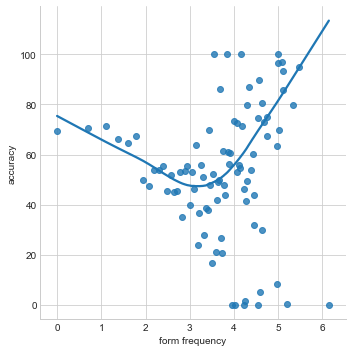

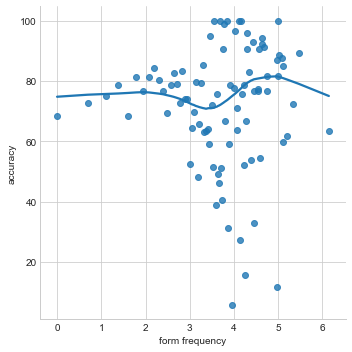

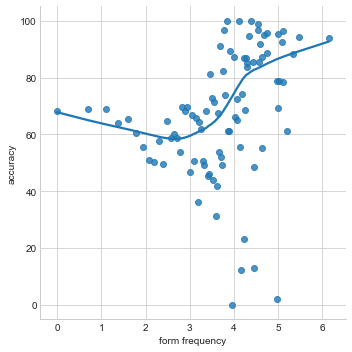

In [18]:
#sns.set(style="ticks")

acc_by_freq={system: OrderedDict() for system in systems}

for system in systems:
        
    for count in sorted(forms_by_log_count.keys()):
        count_forms=forms_by_log_count[count]
        s=0
        for form in count_forms:
            s+=acc_by_form[system][form]
        acc_by_freq[system][count]=s/len(count_forms)
        
        
    dist1=np.array(list(acc_by_freq[system].keys()))
    dist2=np.array(list(acc_by_freq[system].values()))
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

    plot_utils.lmplot(dist1,dist2)
    

### 4) Entropy

**4.1. Prepare classes of entropies with their corresponding forms**

In [19]:
form_entropies={}
for form in ambiguous_forms:
    counts=analysis_utils.get_form_counts(system_articles['spotlight'], form)
    counts=list(counts)
    form_entropies[form]=entropy(counts ,base=len(counts))

In [20]:
forms_per_rentropy=defaultdict(set)
for form, entr in form_entropies.items():
    rounded_entropy=round(entr,1)
    forms_per_rentropy[rounded_entropy].add(form)

**4.2. Plot F1-scores per entropy class**

AGDISTIS
1015 536 954
0.6544165054803353 0.5154900964956831 0.5767045454545454
0.1 0.5767045454545454
819 256 301
0.761860465116279 0.73125 0.7462414578587699
0.2 0.7462414578587699
442 305 367
0.5917001338688086 0.546353522867738 0.5681233933161953
0.3 0.5681233933161953
453 533 556
0.4594320486815416 0.4489593657086224 0.45413533834586467
0.4 0.45413533834586467
343 559 626
0.3802660753880266 0.3539731682146543 0.36664885088188137
0.5 0.36664885088188137
237 528 583
0.30980392156862746 0.2890243902439024 0.29905362776025235
0.6 0.29905362776025235
244 725 794
0.2518059855521156 0.2350674373795761 0.24314897857498757
0.7 0.24314897857498757
277 490 520
0.36114732724902215 0.3475533249686324 0.35421994884910485
0.8 0.35421994884910485
220 380 405
0.36666666666666664 0.352 0.3591836734693878
0.9 0.3591836734693878
274 531 601
0.3403726708074534 0.31314285714285717 0.3261904761904762
1.0 0.3261904761904762
SPOTLIGHT
1542 409 426
0.7903639159405433 0.7835365853658537 0.7869354427149784
0.

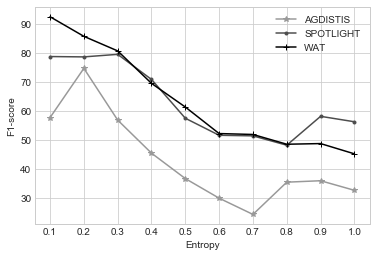

In [21]:

fig = plt.figure()
cnt=0
c=['*', '.', '+']
clr=['0.6', '0.3', '0.0']
for system in systems:
    xs=[]
    ys=[]
    print(system.upper())
    for rentropy, forms_set in sorted(forms_per_rentropy.items()):
        f1=analysis_utils.compute_prf_on_selection(system_articles[system], forms_set)
        print(rentropy, f1)
        xs.append(rentropy)
        ys.append(f1*100.0)
    plt.plot(xs, ys, "%s-" % c[cnt], color=clr[cnt], label=system.upper())
    cnt+=1
plt.legend()
plt.xlabel('Entropy')
plt.ylabel('F1-score')
plt.xticks(xs)
 
plt.show()

save=True
if save:
    fig.savefig('img/entropy_f1.png')


**4.3. Additional analysis: Scatter plot**

The Spearman correlation between X and Y is: -0.04951040643506969 . Significance:  0.2653469220866594
The Spearman correlation between X and Y is: -0.23040307108154878 . Significance:  1.512428595533182e-07
The Spearman correlation between X and Y is: -0.2889134558480473 . Significance:  3.1838082833690196e-11


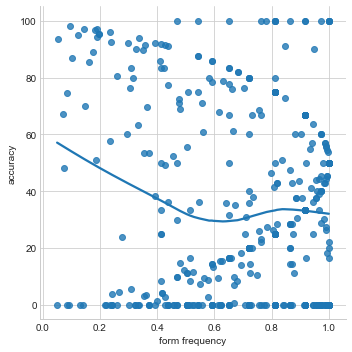

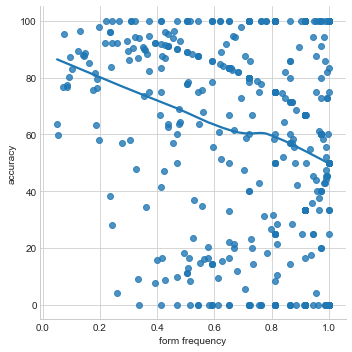

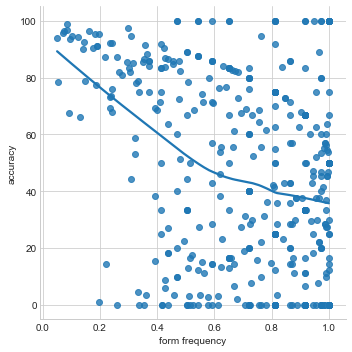

In [22]:
for system in systems:
    dist1=[]
    dist2=[]
    for f in ambiguous_forms:
        dist1.append(form_entropies[f])
        dist2.append(acc_by_form[system][f])

    dist1=np.array(dist1)
    dist2=np.array(dist2)

    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
    
    plot_utils.lmplot(dist1, dist2)

### 5) Correlation between instance frequency and accuracy

<span style="background-color:lightgreen">Section 6.3. of the paper</span>

In [23]:
acc_by_uri = {system: defaultdict(float) for system in systems}
for system in systems:
    acc_by_uri[system], uris_by_count = plot_utils.compute_accuracy_by_uri(
        system_articles[system], skip_nils)

In [24]:
uris_by_log_count=analysis_utils.counts_to_log_counts(uris_by_count)

In [25]:
acc_by_freq_uris={system: OrderedDict() for system in systems}

for system in systems:
        
    for count in sorted(uris_by_log_count.keys()):
        count_uris=uris_by_log_count[count]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_freq_uris[system][count]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_freq_uris[system].keys()))
    dist2=np.array(list(acc_by_freq_uris[system].values()))
    print(system)
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

agdistis
The Spearman correlation between X and Y is: 0.04918630904803034 . Significance:  0.6377953750320826
spotlight
The Spearman correlation between X and Y is: 0.014637670698085024 . Significance:  0.8886393547420061
wat
The Spearman correlation between X and Y is: 0.4679478380233356 . Significance:  1.9773193786232527e-06


### 6) Correlation between instance PageRank and accuracy

In [26]:
skip_zeros=True

In [27]:
uris_by_pr = defaultdict(set)
uri_pr={}
for article in system_articles['spotlight']:
    for entity in article.entity_mentions:
        if entity.sys_link and (not skip_nils or entity.gold_link!='--NME--'):
            pagerank=int(entity.gold_pr)
            if skip_zeros and pagerank==0: continue
            uris_by_pr[pagerank].add(entity.gold_link)
            uri_pr[entity.gold_link]=entity.gold_pr

In [28]:
uris_by_log_pr=analysis_utils.counts_to_log_counts(uris_by_pr)

In [29]:
acc_by_pr_uris={system: OrderedDict() for system in systems}

for system in systems:
        
    for pr in sorted(uris_by_log_pr.keys()):


        count_uris=uris_by_log_pr[pr]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_pr_uris[system][pr]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_pr_uris[system].keys()))
    dist2=np.array(list(acc_by_pr_uris[system].values()))
        
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

The Spearman correlation between X and Y is: 0.0035699393583438067 . Significance:  0.936725376776061
The Spearman correlation between X and Y is: 0.03632857695193204 . Significance:  0.4190223784882491
The Spearman correlation between X and Y is: 0.29534676537276233 . Significance:  1.8401276698079325e-11


### 7) Correlation between instance ranks (of a form) and accuracy

<span style="background-color:lightgreen">Section 6.4. of the paper</span>


**7.1. Collect interpretations for a form**


In [30]:
interpretations=defaultdict(set)
for article in system_articles['spotlight']:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [31]:
interpretations['Marseille']

{'Marseille', 'Olympique_de_Marseille'}

**7.2. Aggregate per rank**

In [32]:
def rank_analysis(systems, system_articles, ambiguous_forms, uri_pr=None, ambiguous_only=True, factor='freq'):

    print(factor)
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(14,3))
    p={}
    r={}
    f1={}

    for system in systems:
        rank_tuples=analysis_utils.prepare_ranks(system_articles[system], 
                                                  ambiguous_forms,
                                                  uri_pr=uri_pr,
                                                  ambiguous_only=ambiguous_only, 
                                                  factor=factor)
        #print(rank_tuples)
        p[system], r[system], f1[system] = analysis_utils.evaluate_ranks(system_articles[system], 
                                                          rank_tuples)

        print()

    plot_utils.plot_prf(p, systems, axs[0], title="PRECISION")
    plot_utils.plot_prf(r, systems, axs[1], title="RECALL")
    plot_utils.plot_prf(f1, systems, axs[2], title="F1-SCORE")

    plt.show()

    fig.savefig('img/accuracy_per_%s_rank.png' % factor, bbox_inches='tight')

freq
tp defaultdict(<class 'int'>, {1: 3830, 2: 411, 3: 44, 5: 1, 6: 1})
fp defaultdict(<class 'int'>, {2: 994, 1: 621, 3: 491, 6: 170, 5: 35, 4: 1})
fn defaultdict(<class 'int'>, {1: 4262, 2: 1086, 3: 242, 4: 78, 8: 2, 5: 20, 9: 2, 6: 8, 11: 1, 7: 3, 12: 1, 10: 2})
precision {1: 0.8604807908335206, 2: 0.29252669039145907, 3: 0.08224299065420561, 4: 0.0, 5: 0.027777777777777776, 6: 0.005847953216374269, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

recall {1: 0.47330696984676224, 2: 0.2745490981963928, 3: 0.15384615384615385, 4: 0.0, 5: 0.047619047619047616, 6: 0.1111111111111111, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

f1 {1: 0.6106991947699912, 2: 0.28325292901447274, 3: 0.1071863580998782, 4: 0.0, 5: 0.03508771929824561, 6: 0.011111111111111112, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}


tp defaultdict(<class 'int'>, {4: 24, 3: 141, 2: 807, 1: 5507, 5: 8, 6: 7, 10: 2})
fp defaultdict(<class 'int'>, {4: 196, 2: 820, 3: 325, 5: 32, 1: 387, 6: 2, 10: 3})
fn 

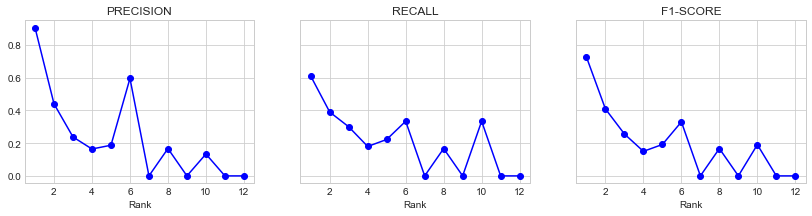

In [33]:
rank_analysis(systems, system_articles, ambiguous_forms, ambiguous_only=True, factor='freq')

#### 7.3 PR ranks


pr
tp defaultdict(<class 'int'>, {1: 3945, 2: 293, 3: 17, 4: 18})
fp defaultdict(<class 'int'>, {1: 1757, 2: 374, 3: 178, 4: 3})
fn defaultdict(<class 'int'>, {1: 2856, 2: 2040, 5: 102, 3: 517, 4: 99, 6: 17, 11: 5, 7: 2, 10: 5, 12: 1, 9: 3, 8: 1})
precision {1: 0.6918625043844265, 2: 0.43928035982008995, 3: 0.08717948717948718, 4: 0.8571428571428571, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

recall {1: 0.580061755624173, 2: 0.12558936990998715, 3: 0.031835205992509365, 4: 0.15384615384615385, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

f1 {1: 0.6310485483483964, 2: 0.19533333333333336, 3: 0.04663923182441702, 4: 0.2608695652173913, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}


tp defaultdict(<class 'int'>, {4: 50, 5: 87, 1: 4902, 6: 13, 3: 159, 2: 1276, 11: 5, 7: 2})
fp defaultdict(<class 'int'>, {4: 213, 1: 534, 5: 97, 3: 215, 6: 80, 2: 621, 7: 3})
fn defaultdict(<class 'int'>, {2: 1057, 3: 375, 4: 67, 1: 1899, 6

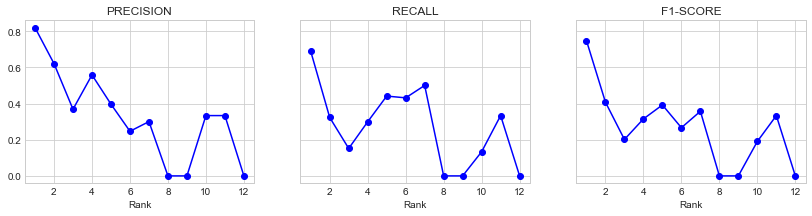

In [34]:
rank_analysis(systems, system_articles, ambiguous_forms, uri_pr=uri_pr, ambiguous_only=True, factor='pr')

### 8) Ambiguity and frequency together against accuracy

In [35]:
def heatmap_me(AMB, FREQ, ACC, system, a, ylbl='', cbar=False):
    data = pd.DataFrame({'AMB': AMB, 'FREQ': FREQ, 'ACC': ACC})
    data_pivoted = data.pivot("FREQ", "AMB", "ACC")
#    fig=plt.figure(figsize = (12,7))
    ax = sns.heatmap(data_pivoted, annot=True, linewidths=.5, ax=a,cbar=cbar,fmt='g')
    ax.set_ylabel(ylbl)
    ax.set_title(system.upper())
    for _, spine in ax.spines.items():
        spine.set_edgecolor('darkblue')
        spine.set_visible(True)
#    plt.show()
#    fig.savefig('img/%s_amb_frequency_acc.png' % system)

In [36]:
def split_forms_per_amb_freq_pair(ambiguity, forms_by_log_count):
    af_pairs=defaultdict(set)
    for log_freq, forms in forms_by_log_count.items():
        for form in forms:
            amb=ambiguity[form]
            rounded_freq=round(log_freq)
            af_pairs[(amb, rounded_freq)].add(form)
    return af_pairs

In [37]:
def evaluate_af_pairs(af_pairs, articles, skip_nils=True):
    
    tp=defaultdict(int)
    fn=defaultdict(int)
    fp=defaultdict(int)
    
    counts=defaultdict(set)
    for article in articles:
        for mention in article.entity_mentions:
            gold = mention.gold_link
            syslink = mention.sys_link
            form = mention.mention
            if skip_nils and gold=='--NME--':
                continue
            this_pair=None
            for pair, forms in af_pairs.items():
                if form in forms:
                    this_pair=pair
            if not this_pair:
                continue
            else:
                counts[this_pair].add(form)
            if gold==syslink:
                tp[this_pair]+=1
            else:
                if syslink!='--NME--':
                    fp[this_pair]+=1
                fn[this_pair]+=1
    
    agg_counts={}
    for pair, forms in counts.items():
        agg_counts[pair]=len(forms)
    
    prec=defaultdict(float)
    recall=defaultdict(float)
    f1=defaultdict(int)
    
    for pair in af_pairs.keys():
        prec[pair]=tp[pair]/(tp[pair]+fp[pair])
        recall[pair]=tp[pair]/(tp[pair]+fn[pair])
        if prec[pair]+recall[pair]>0:
            f1[pair]=int(100.0*2*prec[pair]*recall[pair]/(prec[pair]+recall[pair]))
        else:
            f1[pair]=0
    
    return f1, agg_counts

In [38]:
total_per_form = analysis_utils.get_freq_totals(system_articles[systems[0]], ambiguous_forms, ambiguous_only=False)
af_pairs=split_forms_per_amb_freq_pair(ambiguity, forms_by_log_count)

In [39]:
def plot_heatmap(data, cnt, axs=None, system=''):
    AMB=[]
    FREQ=[]
    ACC=[]

    for this_pair, val in data.items():

        ACC.append(val)
        AMB.append(this_pair[0])
        mn=freq_intervals[this_pair[1]][0]
        mx=freq_intervals[this_pair[1]][1]
        FREQ.append(freq_intervals[this_pair[1]])
    if cnt>0:
        ylbl=''
    else:
        ylbl='FREQ'
    heatmap_me(AMB, FREQ, ACC, system, axs[cnt], cbar=(cnt==2), ylbl=ylbl)


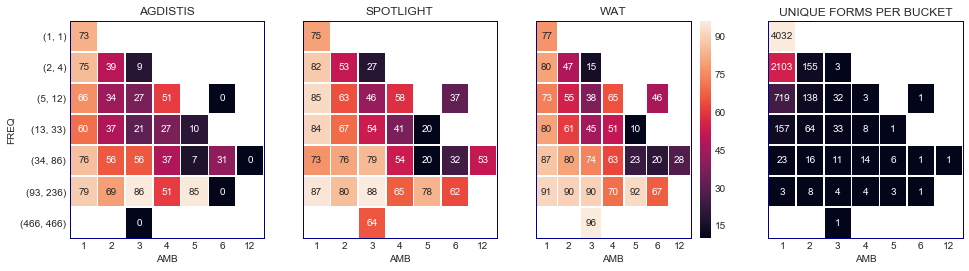

In [40]:
fig, axs = plt.subplots(ncols=4, sharey=True,figsize=(16,4))
cnt=0

for system in systems:
    
    f1s, counts = evaluate_af_pairs(af_pairs, system_articles[system])
    
    plot_heatmap(f1s, cnt, axs, system)

    cnt+=1
    
plot_heatmap(counts, cnt, axs, 'unique forms per bucket')
    
plt.show()
fig.savefig('img/amb_frequency_acc.png')

### 9) Frequency baseline

In [41]:
s='x freq baseline'

totals=analysis_utils.get_freq_totals(system_articles[systems[0]],
                                      set(),
                                      ambiguous_only=False
                                     )
freq_baseline_articles=deepcopy(system_articles['agdistis'])
pr_baseline_articles=deepcopy(system_articles['agdistis'])



In [42]:
form_to_mostfreq=defaultdict(lambda: '--NME--')
form_to_highest_pr = defaultdict(lambda: '--NME--')
for form, dist in totals.items():
    key_max = max(dist.keys(), key=(lambda k: dist[k]))
    form_to_mostfreq[form]=key_max

In [43]:
for article in freq_baseline_articles:
    for mention in article.entity_mentions:
        mention.sys_link=form_to_mostfreq[mention.mention]
        print(mention.sys_link)

--NME--
London
London
--NME--
London
Jakarta
Iran
Basra
Mir-Hossein_Mousavi
--NME--
Mir-Hossein_Mousavi
BBC
--NME--
Iran
Iran
Iraq
Mir-Hossein_Mousavi
--NME--
Saddam_Hussein
Islamic_Republic_News_Agency
Basra
Baghdad
Ahvaz
Japan_national_football_team
Syria_national_football_team
Al_Ain
United_Arab_Emirates
Japan
AFC_Asian_Cup
Syria
Takuya_Takagi
--NME--
Syria_national_football_team
Hassan_Abbas
--NME--
Syria
--NME--
--NME--
Kenichi_Shimokawa
Japan
Syria_national_football_team
--NME--
Kazuyoshi_Miura
Takuya_Takagi
--NME--
Kazuyoshi_Miura
Japan
--NME--
Naoki_Sōma
Japan
Kenichi_Shimokawa
Hiroshige_Yanagimoto
Naoki_Sōma
Masami_Ihara
Norio_Omura
Motohiro_Yamaguchi
Masakiyo_Maezono
Yasuto_Honda
Takuya_Takagi
Hiroshi_Nanami
Kazuyoshi_Miura
Hiroaki_Morishima
Masayuki_Okano
Syria
--NME--
--NME--
Hassan_Abbas
Tarek_Jabban
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
Khaled_Al_Zaher
--NME--
--NME--
Quincy_High_School_(Massachusetts)
Akron,_Ohio
Ohio
--NME--
New_York_City
--NME--
Akron

Angelique_Kerber
Tímea_Babos
Boston_Red_Sox
Bobby_Valentine
Bill_Clinton
Democratic_Party_(United_States)
Chicago_White_Sox
Bill_Clinton
Democratic_Party_(United_States)
White_House
Bill_Clinton
Republican_Party_(United_States)
Bob_Dole
Cleveland_Indians
New_Delhi
India
Supreme_Court_of_the_United_States
Andhra_Pradesh
--NME--
Bobby_Valentine
Yahoo!
Seattle_Mariners
Eric_Wedge
British_Airways
--NME--
Turkey_national_football_team
Kurdistan
Ankara
Ottoman_Empire
Kurdistan
Anatolia
Kurdistan_Workers'_Party
Kurdistan_Workers'_Party
Van,_Turkey
Şırnak_Province
Hakkâri
Kurdistan_Workers'_Party
Turkey_national_football_team
Kurdistan_Workers'_Party
Anatolia
Kurdistan
Kurdistan_Workers'_Party
--NME--
--NME--
--NME--
New_York_City
--NME--
--NME--
Michigan_National_Bank
Detroit
--NME--
Detroit
--NME--
Detroit
--NME--
Russia
Chechnya
Grozny
Grozny
Russia
Russia
Greenwich_Mean_Time
Chechnya
Grozny
Russia
--NME--
Russia
T-72
Grozny
Russia
--NME--
Russia
Alexander_Lebed
Aslan_Maskhadov
Grozny
--NME

Inzamam-ul-Haq
Nasser_Hussain
Alan_Mullally
Saleem_Malik
Asif_Mujtaba
Wasim_Akram
Alec_Stewart
Robert_Croft
Moin_Khan
Ian_Salisbury
Mushtaq_Ahmed
John_Crawley
Alan_Mullally
Waqar_Younis
--NME--
Carl_Lewis
Alan_Mullally
Robert_Croft
Dominic_Cork
Ian_Salisbury
England
--NME--
--NME--
Wasim_Akram
Waqar_Younis
Mushtaq_Ahmed
--NME--
Xcel_Energy
--NME--
--NME--
--NME--
Unión_de_Santa_Fe
Xcel_Energy
Unión_de_Santa_Fe
Denver
Colorado_Public_Utilities_Commission
--NME--
Unión_de_Santa_Fe
Xcel_Energy
--NME--
--NME--
Colorado_House_of_Representatives
Unión_de_Santa_Fe
Xcel_Energy
Reuter
--NME--
--NME--
--NME--
Olympique_de_Marseille
Élie_Baup
South_Korea
Seoul
South_Korea
--NME--
--NME--
--NME--
--NME--
--NME--
Hanwha_Eagles
Hanwha_Eagles
--NME--
--NME--
--NME--
Samsung_Heavy_Industries
--NME--
--NME--
--NME--
--NME--
Hanwha_Eagles
--NME--
--NME--
Hanwha_Eagles
--NME--
Samsung_Heavy_Industries
--NME--
--NME--
--NME--
Dunkin'_Donuts
Boston_Red_Sox
Action_News
--NME--
Manchester_City_F.C.
Chelsea_F

Iraq
Kurdistan
Kurdistan
Patriotic_Union_of_Kurdistan
Patriotic_Union_of_Kurdistan
Patriotic_Union_of_Kurdistan
Iraq
Kurdistan
Saddam_Hussein
Patriotic_Union_of_Kurdistan
Kurdistan_Democratic_Party
Kurdistan_Democratic_Party
Patriotic_Union_of_Kurdistan
Kurdistan_Democratic_Party
Patriotic_Union_of_Kurdistan
Iran
Iraqi_Kurdistan
--NME--
Patriotic_Union_of_Kurdistan
United_Nations
Iraq
United_States
France
United_Kingdom
Iraqi_Kurdistan
Baghdad
Gulf_War
Operation_Provide_Comfort
Turkey_national_football_team
--NME--
--NME--
--NME--
--NME--
--NME--
United_States_Army
Madrid
Ángel_Di_María
Switzerland
Geneva
Switzerland
FC_Aarau
BSC_Young_Boys
Grasshopper_Club_Zürich
FC_Luzern
FC_Lugano
--NME--
Neuchâtel
FC_St._Gallen
FC_Sion
Servette_FC
Neuchâtel
Grasshopper_Club_Zürich
--NME--
FC_Lausanne-Sport
FC_Aarau
FC_Sion
Zürich
--NME--
Servette_FC
FC_Luzern
FC_Lugano
BSC_Young_Boys
China
--NME--
--NME--
China
Xiao_Qiang
New_York
Human_Rights_in_China_(organization)
--NME--
--NME--
Communist_Party

European_Commission
--NME--
European_Union
--NME--
Franz_Fischler
--NME--
--NME--
United_Kingdom
France
--NME--
Bovine_spongiform_encephalopathy
--NME--
--NME--
Spain
Loyola_de_Palacio
--NME--
--NME--
France
United_Kingdom
--NME--
--NME--
Bovine_spongiform_encephalopathy
United_Kingdom
Germany
United_Kingdom
Europe
Germany
--NME--
--NME--
--NME--
--NME--
Bonn
United_Kingdom
Germany
United_Kingdom
United_Kingdom
Netherlands
Amsterdam
Netherlands
--NME--
RKC_Waalwijk
Willem_II_(football_club)
Fortuna_Sittard
NAC_Breda
Sparta_Rotterdam
SC_Heerenveen
AFC_Ajax
--NME--
Fortuna_Sittard
PSV_Eindhoven
FC_Twente
Vitesse
SC_Heerenveen
NAC_Breda
AFC_Ajax
FC_Utrecht
Feyenoord
Roda_JC_Kerkrade
FC_Volendam
FC_Groningen
RKC_Waalwijk
Sparta_Rotterdam
Willem_II_(football_club)
AZ_Alkmaar
N.E.C._(football_club)
Metro_AG
Singapore
--NME--
Singapore
--NME--
Greenwich_Mean_Time
Metro_AG
--NME--
--NME--
--NME--
--NME--
Singapore
Bob_Baffert
--NME--
Rwanda
Nairobi
Rwanda
Democratic_Republic_of_the_Congo
--NME

--NME--
--NME--
--NME--
--NME--
Thomas_Bscher
Jean-Marc_Gounon
Bernard_Collomb
Paul_Belmondo
--NME--
--NME--
--NME--
Pierre-Henri_Raphanel
Rugby_union
London
United_Kingdom
Anglo-Welsh_Cup
Reading_F.C.
Widnes_Vikings
England
Bath_Rugby
Harlequin_F.C.
Gloucester_Rugby
London_Irish
Orrell_R.U.F.C.
West_Hartlepool_R.F.C.
Wasps_RFC
Bristol_Rugby
Wales
Caerphilly_RFC
Cardiff_City_F.C.
Llanelli_RFC
Newbridge_RFC
Newport_RFC
Dunvant_RFC
Pontypridd
Bridgend_Ravens
Swansea_City_A.F.C.
Neath_RFC
Treorchy_RFC
Ebbw_Vale_RFC
Scotland
Boroughmuir_RFC
Watsonians_RFC
--NME--
--NME--
Fayetteville,_West_Virginia
--NME--
--NME--
--NME--
Glenn_McGrath
Republic_of_Ireland
1998_FIFA_World_Cup
Dublin
Republic_of_Ireland
Paul_McGrath_(footballer)
Mick_McCarthy
Liechtenstein_national_football_team
1998_FIFA_World_Cup
Aston_Villa_F.C.
Republic_of_Ireland
Czech_Republic
Prague
--NME--
Aston_Villa_F.C.
Mick_McCarthy
--NME--
FC_Vaduz
Alan_Kernaghan
Liam_Daish
Leeds_United_F.C.
Gary_Kelly_(footballer,_born_1974)
Th

Brazilian_Football_Confederation
Brazilian_Football_Confederation
Rio_de_Janeiro
Moscow
Brazil
Russia
--NME--
Santos_FC
Narciso_dos_Santos
Jean_Carlo_Witte
São_Paulo
São_Paulo
Esporte_Clube_Juventude
Sport_Club_Internacional
Sport_Club_Corinthians_Paulista
Spain
Spain
São_Paulo
Curitiba
Clube_Atlético_Paranaense
Brazil
Botafogo_de_Futebol_e_Regatas
Túlio_Maravilha
--NME--
Netherlands
Esporte_Clube_Bahia
Túlio_Maravilha
ʻEwa_Beach,_Hawaii
Aiea,_Hawaii
Czech_Republic
Prague
--NME--
--NME--
--NME--
Josef_Zieleniec
Josef_Zieleniec
Reuters
--NME--
Václav_Klaus
Czech_Republic
Brno
--NME--
--NME--
United_Kingdom
Margaret_Thatcher
Czech_Republic
Josef_Zieleniec
--NME--
Post-communism
--NME--
Czech_Republic
--NME--
--NME--
Social_Democratic_Party_of_Germany
--NME--
Sudan
London_Stansted_Airport
England
Sudan
London
London_Stansted_Airport
--NME--
--NME--
London_Stansted_Airport
Cyprus
Khartoum
Amman
Iraq
--NME--
Germany
Bosnia_and_Herzegovina
--NME--
Bonn
Volker_Rühe
Germany
Bosnia_and_Herzegov

--NME--
FC_Barcelona
--NME--
UEFA_Champions_League
S.L._Benfica
Portugal
Wembley_Arena
Juventus_F.C.
UEFA_Champions_League
AFC_Ajax
Manchester_United_F.C.
England
Liverpool_F.C.
King_Baudouin_Stadium
Brussels
Islam
--NME--
--NME--
Matuzići
Bosnia_and_Herzegovina
Islam
Bosnia_and_Herzegovina
Serbia
--NME--
Doboj
NATO
Matuzići
Doboj
Bosnia_and_Herzegovina
United_Nations
European_Union
Doboj
Bosnia_and_Herzegovina
--NME--
Islam
--NME--
Serbia
Islam
Serbs
Bosnia_and_Herzegovina
Doboj
Dayton_Agreement
--NME--
Doboj
Islam
--NME--
Doboj
Serbs
Doboj
Bosnia_and_Herzegovina
--NME--
Bosnia_and_Herzegovina
Ejup_Ganić
Islam
Serbs
Doboj
Doboj
Doboj
Serbs
Dayton_Agreement
Islam
Serbia
Croatia
Bosnia_and_Herzegovina
Bosnia_and_Herzegovina
Islam
--NME--
--NME--
Doboj
--NME--
Doboj
Islam
Serbs
Islam
Belgium_national_football_team
Turkey_national_football_team
--NME--
Brussels
Belgium
1998_FIFA_World_Cup
Turkey_national_football_team
Ottoman_Empire
Ottoman_Empire
--NME--
Ottoman_Empire
Belgium
Filip_De_W

Pakistan_national_cricket_team
Karachi
Germany
Frankfurt
Germany
Germany
--NME--
Berlin
Berlin_Tegel_Airport
Berlin_Tempelhof_Airport
--NME--
Bremen_Airport
Dresden_Airport
--NME--
Frankfurt
Hamburger_SV
--NME--
--NME--
1._FC_Köln
Leipzig/Halle_Airport
--NME--
Munich_Airport
--NME--
--NME--
Nuremberg_Airport
--NME--
VfB_Stuttgart
--NME--
General_Electric_Company_plc
General_Electric_Company_plc
General_Electric_Company_plc
London
United_States
United_States
--NME--
General_Electric_Company_plc
General_Electric_Company_plc
Reuter
Dhaka
Dhaka
Dhaka_Stock_Exchange
--NME--
Islam
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
Asarco
Asarco
First_Boston
Czech_Republic
--NME--
Prague
Prague_Stock_Exchange
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
Komerční_banka
--NME--
--NME--
--NME--
OKD
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
England_cricket_team
Pakistan_national_cricket_team
Manchester
England
E

--NME--
--NME--
Hanwha_Eagles
Samsung_Heavy_Industries
--NME--
--NME--
--NME--
Arthur_Caplan
--NME--
--NME--
--NME--
--NME--
Sri_Lanka_national_cricket_team
Australia_national_cricket_team
Colombo
Sri_Lanka_national_cricket_team
Australia
Sri_Lanka_national_cricket_team
Sri_Lanka_national_cricket_team
Muttiah_Muralitharan
Australia
Sri_Lanka_national_cricket_team
Arjuna_Ranatunga
1998_FIFA_World_Cup
World_Series_Cricket_World_XI
Australia
--NME--
Arjuna_Ranatunga
--NME--
Australia_national_cricket_team
--NME--
1998_FIFA_World_Cup
Colombo
Australia
India
Zimbabwe
--NME--
Sri_Lanka
Australia
Ian_Healy
Sri_Lanka_national_cricket_team
London
London
Lantau_Peak
Hay_Point,_Queensland
Newcastle_United_F.C.
Kaohsiung
China_Steel
Royal_Clipper
Maracaibo
Fos-sur-Mer
--NME--
Dampier,_Western_Australia
Kaohsiung
China_Steel
Germany
Berlin
Germany
--NME--
Netherlands
Velten
Berlin
Reuters
France
Céline_Dumerc
Bill_Clinton
Washington,_D.C.
Bill_Clinton
White_House
White_House
Mike_McCurry_(press_sec

Kawasaki_Heavy_Industries
--NME--
Japan
Kawasaki_Heavy_Industries
Noriyuki_Haga
Takuma_Aoki
Japan
Honda
John_Kocinski
Noriyuki_Haga
Aaron_Slight
Carl_Fogarty
--NME--
--NME--
--NME--
Wataru_Yoshikawa
Troy_Corser
Takuma_Aoki
Aaron_Slight
Troy_Corser
John_Kocinski
Carl_Fogarty
Colin_Edwards
United_States
Yamaha_Motor_Company
--NME--
Italy
Ducati
Simon_Crafar
New_Zealand
Kawasaki_Heavy_Industries
Anthony_Gobert
Australia
Kawasaki_Heavy_Industries
Wataru_Yoshikawa
Neil_Hodgson
United_Kingdom
Ducati
Japan
Noriyuki_Haga
Takuma_Aoki
Japan
Honda
John_Kocinski
Aaron_Slight
Carl_Fogarty
--NME--
--NME--
--NME--
Wataru_Yoshikawa
Troy_Corser
--NME--
Japan
Suzuki
Takuma_Aoki
Aaron_Slight
Troy_Corser
John_Kocinski
Carl_Fogarty
Colin_Edwards
United_States
Yamaha_Motor_Company
--NME--
Italy
Ducati
Simon_Crafar
New_Zealand
Kawasaki_Heavy_Industries
Anthony_Gobert
Australia
Kawasaki_Heavy_Industries
Wataru_Yoshikawa
Neil_Hodgson
United_Kingdom
Ducati
China_Times
--NME--
Australia_national_cricket_team
Sri

--NME--
Florence
--NME--
--NME--
--NME--
France
United_Kingdom
René_(novella)
France
--NME--
Los_Angeles
Spain
--NME--
--NME--
Anton_Bruckner
Austria
France
Second_French_Empire
Napoleon_III
--NME--
Skeleton_Canyon
Arizona
Geronimo
Native_Americans_in_the_United_States
Nelson_A._Miles
France
Darius_Milhaud
La_création_du_monde
Madame_Bovary
United_States
Max_Delbrück
Nobel_Prize
Edvard_Grieg
Norway
Peer_Gynt
Bergen
United_States
Edward_Dmytryk
Crossfire_(film)
Hollywood
--NME--
--NME--
Crystal_Palace_F.C.
London
Brussels
Antwerp
Belgium
United_Kingdom
Canada
World_War_II
Wilhelmina_of_the_Netherlands
Netherlands
--NME--
World_War_II
Juliana_of_the_Netherlands
Robert_Schuman
France
--NME--
Forth_Road_Bridge
Scotland
Albert_Schweitzer
Gabon
Johann_Sebastian_Bach
Nobel_Peace_Prize
--NME--
1972_Summer_Olympics
United_States
Mark_Spitz
Olympiad
East_Germany
United_States
--NME--
Small_Is_Beautiful
Switzerland
Georges_Simenon
Jules_Maigret
Bulgaria
Communist_party
Todor_Zhivkov
Jerusalem
Isr

Republika_Srpska
Islam
Mahala
--NME--
Bosnia_and_Herzegovina
NATO
Serbs
Serbia
United_Nations
Zvornik
Mahala
--NME--
NATO
AK-47
Serbs
Zvornik
Mahala
Zvornik
--NME--
Azad_Kashmir
Muzaffarabad
Pakistan_national_cricket_team
--NME--
--NME--
--NME--
Kashmir
Islam
Kunar_River
Muzaffarabad
Pakistan
Garhi_Habibullah
General_Motors
--NME--
S.S.D._Parma_Calcio_1913
A.S._Roma
Udinese_Calcio
Coppa_Italia
Rome
UEFA_Europa_League
S.S.D._Parma_Calcio_1913
A.S._Roma
Coppa_Italia
A.C._Milan
Empoli_F.C.
S.S.D._Parma_Calcio_1913
Italy
Carlo_Ancelotti
Enrico_Chiesa
Delfino_Pescara_1936
Delfino_Pescara_1936
--NME--
S.S.D._Parma_Calcio_1913
--NME--
S.S.D._Parma_Calcio_1913
Alessandro_Melli
Serie_A
S.S.D._Parma_Calcio_1913
U.S._Città_di_Palermo
A.S._Roma
Argentina
Carlos_Bianchi
Italy
Arrigo_Sacchi
A.C._Cesena
Rome
Udinese_Calcio
Germany
--NME--
Oliver_Bierhoff
Serie_A
U.S._Cremonese
A.C._Milan
Uruguay
Óscar_Tabárez
Coppa_Italia
ACF_Fiorentina
Cosenza_Calcio_1914
UEFA_Champions_League
Juventus_F.C.
S.S._Fid

Pakistan_national_cricket_team
--NME--
West_Virginia_State_University
National_Football_League
New_York_City
National_Football_League
United_States
New_England_Patriots
Buffalo_Sabres
Indianapolis_Colts
Miami_Heat
New_York_Jets
--NME--
Houston_Astros
Jacksonville_Jaguars
Cincinnati_Reds
Baltimore_Orioles
--NME--
Kansas_City_Royals
San_Diego_Padres
Oakland_Athletics
Seattle_Mariners
Dallas_Stars
Washington,_D.C.
Philadelphia_Phillies
Arizona_Cardinals
New_York_Giants
--NME--
Minnesota_Twins
Chicago_White_Sox
Detroit_Tigers
Tampa_Bay_Lightning
San_Francisco_Giants
Carolina_Panthers
St._Louis_Blues
Atlanta_Braves
New_Orleans_Saints
St._Louis_Blues
Chicago_White_Sox
Baltimore_Orioles
Cincinnati_Reds
Denver_Nuggets
Green_Bay_Packers
Jacksonville_Jaguars
Houston_Astros
New_York_Giants
Miami_Heat
Atlanta_Braves
New_Orleans_Saints
San_Diego_Padres
Pittsburgh_Pirates
Washington,_D.C.
Tampa_Bay_Lightning
Dallas_Stars
Arizona_Cardinals
New_York_Jets
New_England_Patriots
Buffalo_Sabres
Seattle_Mar

--NME--
--NME--
Mick_McCarthy
Mick_McCarthy
--NME--
--NME--
--NME--
--NME--
--NME--
--NME--
Johannesburg
Estonia
--NME--
Tallinn
--NME--
Estonia
--NME--
--NME--
--NME--
New_York_City
--NME--
Morgan_Stanley
--NME--
--NME--
New_York_Stock_Exchange
--NME--
--NME--
Medicare_(United_States)
--NME--
Amsterdam
--NME--
Amsterdam
British_Masters
Northampton
England
British_Masters
Robert_Allenby
Australia
Pedro_Linhart
Spain
Miguel_Ángel_Martín_(golfer)
Spain
Costantino_Rocca
Italy
--NME--
France
Ian_Woosnam
--NME--
Spain
--NME--
South_Africa
Stephen_McAllister
Joakim_Haeggman
Sweden
José_Cóceres
Argentina
Paul_Eales
Klas_Eriksson
Sweden
--NME--
Australia
Mark_Roe
Eamonn_Darcy
Republic_of_Ireland
Bob_May_(golfer)
United_States
Paul_Lawrie
Miguel_Ángel_Jiménez
Spain
Peter_Mitchell_(golfer)
Philip_Walton
Republic_of_Ireland
Peter_O'Malley
Australia
Barry_Lane
Wayne_Riley
Australia
--NME--
Bradley_Hughes_(golfer)
Australia
Peter_Hedblom
Sweden
Retief_Goosen
South_Africa
David_Gilford
Linford_Chris

Montpellier_HSC
SC_Bastia
Lille_OSC
AS_Cannes
AS_Monaco_FC
Stade_Rennais_F.C.
FC_Girondins_de_Bordeaux
Olympique_Lyonnais
AS_Nancy
OGC_Nice
En_Avant_de_Guingamp
FC_Metz
RC_Strasbourg_Alsace
Le_Havre_AC
Stade_Malherbe_Caen
AJ_Auxerre
Olympique_de_Marseille
Amazon_River
Jeff_Bezos
Brazil
Rio_de_Janeiro
Brazil
Esporte_Clube_Bahia
Clube_Atlético_Paranaense
Sport_Club_Corinthians_Paulista
Guarani_FC
Coritiba_Foot_Ball_Club
Clube_Atlético_Mineiro
Cruzeiro_Esporte_Clube
Esporte_Clube_Vitória
Clube_de_Regatas_do_Flamengo
Esporte_Clube_Juventude
Goiás_Esporte_Clube
Sport_Club_do_Recife
Grêmio_Foot-Ball_Porto_Alegrense
Clube_Atlético_Bragantino
Sociedade_Esportiva_Palmeiras
CR_Vasco_da_Gama
Associação_Portuguesa_de_Desportos
Paraná_Clube
Data_I/O
--NME--
Federal_Highway_Administration
Victor_Mendez
FC_Bayern_Munich
Bundesliga
Bonn
Thomas_Helmer
Jürgen_Klinsmann
FC_Bayern_Munich
Bayer_04_Leverkusen
Bundesliga
FC_Bayern_Munich
VfB_Stuttgart
Brazil
Paulo_Sérgio_Silvestre_do_Nascimento
Bayer_04_Leve

Spain
Anne-Gaëlle_Sidot
France
Janette_Husárová
Slovakia
Brenda_Schultz-McCarthy
Netherlands
Nana_Smith
Japan
Aleksandra_Olsza
Poland
Magdalena_Maleeva
Bulgaria
Michael_Stich
Germany
Tommy_Haas
Germany
Sergi_Bruguera
Spain
--NME--
Belgium
--NME--
France
Ramón_Delgado
Paraguay
--NME--
Slovakia
Gala_León_García
Spain
Åsa_Svensson
Sweden
Gloria_Pizzichini
Italy
Barbara_Schett
Austria
Sabine_Appelmans
Belgium
--NME--
Spain
Sabine_Hack
Germany
Helena_Suková
Czech_Republic
--NME--
Japan
Irina_Spîrlea
Romania
--NME--
Germany
--NME--
Argentina
--NME--
Austria
Carlos_Moyá
Spain
Scott_Humphries
United_States
Kenneth_Carlsen
Denmark
Pat_Rafter
Australia
Magnus_Gustafsson
Sweden
Carlos_Costa
Spain
Jeff_Tarango
United_States
Alex_Rădulescu
Romania
MaliVai_Washington
United_States
Karim_Alami
Morocco
--NME--
Germany
Chuck_Adams
United_States
Jason_Stoltenberg
Australia
Stefano_Pescosolido
Italy
Arnaud_Boetsch
France
Nicolás_Pereira
Venezuela
David_Prinosil
Germany
Peter_Tramacchi
Australia
Amanda_Co

Sudan
Cyprus
United_Kingdom
Larnaca
Cyprus
Sudan_Airways
Cyprus
Larnaca
United_Kingdom
--NME--
Khartoum
Amman
Jordan
London
--NME--
--NME--
German_Open_(golf)
Stuttgart
Germany
German_Open_(golf)
United_Kingdom
Ian_Woosnam
Robert_Karlsson
Sweden
--NME--
Spain
Iain_Pyman
Carl_Suneson
--NME--
Miguel_Ángel_Martín_(golfer)
Spain
Raymond_Russell
--NME--
Germany
Paul_Broadhurst
Diego_Borrego
Spain
--NME--
Stephen_Ames
--NME--
Eamonn_Darcy
Republic_of_Ireland
Robert_Coles_(golfer)
--NME--
Thomas_Bjørn
Denmark
Pedro_Linhart
Spain
Michael_Jonzon
Sweden
Roger_Chapman_(golfer)
Jonathan_Lomas
--NME--
Spain
Terry_Price_(golfer)
Australia
Paul_Eales
Wayne_Riley
Australia
Carl_Mason
Barry_Lane
Bernhard_Langer
Germany
Gary_Orr
Mats_Lanner
Sweden
--NME--
Des_Smyth
Republic_of_Ireland
David_Carter_(golfer)
Steve_Webster
José_María_Cañizares
Spain
Paul_Lawrie
France
--NME--
Aberdeen_F.C.
--NME--
Scotland
France
Antoine_Kombouaré
Aberdeen_F.C.
Switzerland
FC_Sion
Scotland
--NME--
Greenock_Morton_F.C.
Scot

--NME--
Soviet_Union
Boris_Yeltsin
Russia
Russia
--NME--
Russia
Russia
--NME--
--NME--
ACF_Fiorentina
Gabriel_Batistuta
Milan
Argentina
Gabriel_Batistuta
ACF_Fiorentina
Coppa_Italia
--NME--
Serie_A
A.C._Milan
Florence
Coppa_Italia
Coppa_Italia
Gabriel_Batistuta
ACF_Fiorentina
Sweden
Stefan_Schwarz
Gabriel_Batistuta
Franco_Baresi
Montenegro
Dejan_Savićević
ACF_Fiorentina
Francesco_Toldo
Gabriel_Batistuta
France
Marcel_Desailly
Argentina
Boca_Juniors
ACF_Fiorentina
A.C._Milan
Óscar_Tabárez
Gabriel_Batistuta
Gabriel_Batistuta
ACF_Fiorentina
ACF_Fiorentina
A.C._Milan
George_Weah
Italy
Roberto_Baggio
Netherlands
Edgar_Davids
A.C._Milan
--NME--
--NME--
--NME--
New_York_City
United_States
--NME--
United_States
--NME--
United_States
--NME--
--NME--
--NME--
--NME--
--NME--
United_States
--NME--
--NME--
--NME--
Equitas
Equitas
--NME--
Greenwich_Mean_Time
--NME--
--NME--
United_States
--NME--
--NME--
United_States
--NME--
--NME--
United_States_courts_of_appeals
United_States_Court_of_Appeals_for_

In [44]:
sys_acc=analysis_utils.overall_performance_prf(freq_baseline_articles, skip_nils=True, skip_nonnils=False)
print(sys_acc)
all_sys_accs[s]['overall']=sys_acc


27089 1902 1902
0.9343934324445518 0.9343934324445518 0.9343934324445516
0.9343934324445516


In [45]:
amb_f_acc=analysis_utils.compute_prf_on_selection(freq_baseline_articles, ambiguous_forms)
all_sys_accs[s]['ambiguous forms']=amb_f_acc

nn_f_acc=analysis_utils.compute_prf_on_selection(freq_baseline_articles, nil_nonnil_forms)
all_sys_accs[s]['forms with nils & non-nils']=nn_f_acc

8092 2099 1902
0.7940339515258561 0.8096858114868921 0.8017835026009412
2054 899 220
0.6955638333897731 0.9032541776605101 0.785919265352975


['overall', 'ambiguous forms', 'forms with nils & non-nils']
['agdistis' 'spotlight' 'wat' 'x freq baseline']
width: 0.2333333333333333
evaluation: overall
0.6170835986536887
0.7601624555224096
0.7544708354811849
0.9343934324445516
evaluation: ambiguous forms
0.4504635899572872
0.6518949268097053
0.6861764871089142
0.8017835026009412
evaluation: forms with nils & non-nils
0.4990083300277668
0.5685063681976071
0.6786341463414635
0.785919265352975


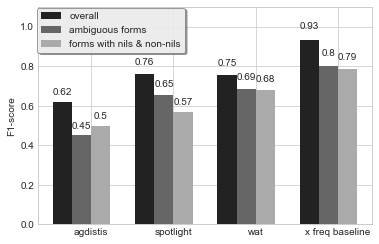

In [46]:
scores=analysis_utils.prepare_scores_to_plot(all_sys_accs)
plot_utils.plot_scores(scores, title='Scores of systems')
